# (Try to) Extract Gentrification-Relevant Information from public data using a Large Language Model

Apply an LLM to various datasets  to try to extract those that might be indicative of some kind of gentrification.

Data included so far:

  - Historic tweets
  - FourSquare tips

## Libraries

In [1]:
import os
import re

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

#from kaggle.api.kaggle_api_extended import KaggleApi  # pip install kaggle
from together import Together  # pip install together


# Easier display options for debugging: 

# Set the display width to a larger value
pd.set_option('display.width', 1000)

# Optionally, set the max column width to avoid truncating column data
pd.set_option('display.max_colwidth', None)

# Optionally, set the max number of columns to show all columns
pd.set_option('display.max_columns', None)

## Open Twitter data

Currently use a historic library of tweets that were downloaded using various APIs by the researchers.

In [3]:
# Read a small sample dataset I created for testing 
#tweets_df = pd.read_csv(os.path.join("..", "data", "uk_tweets", "uk_tweets-2017-02-15.sample.csv"),
#                        quotechar='"',
#                        skipinitialspace=True)

# Read the full dataset, but optionally skip loads of rows to make it smaller
# (in future read the whole thing and then start to filter, e.g. by removing tweets without coordinates or outside the study area)
num_skip = 500  # Read only one in every num_skip rows
tweets_df = pd.read_csv(
    os.path.join("..", "data", "uk_tweets", "uk_tweets-2017-02-15.csv.gz"),
    quotechar='"',
    skipinitialspace=True,
    skiprows=lambda x: x != 0 and x % num_skip != 0  # Skip rows that aren't 0 (need the header) or where they're not a multiple of num_skip
)

In [4]:
print(tweets_df.columns)
tweets_df

Index(['id', 'user-id', 'user-screen_name', 'geo-coordinates-0', 'geo-coordinates-1', 'coordinates-coordinates-0', 'coordinates-coordinates-1', 'place-full_name', 'created_at', 'text', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second'], dtype='object')


id             user-id user-screen_name  geo-coordinates-0  geo-coordinates-1  coordinates-coordinates-0  coordinates-coordinates-1        place-full_name                      created_at                                                                                                                                    text  Year  Month  Day  Hour  Minute  Second
0       672783702498410496           131108904     owaindaviess                NaN                NaN                        NaN                        NaN          Tumble_ Wales  Fri Dec 04 14:25:09 +0000 2015                                                                                                        Crack on https://t.co/vTQs6JQJ2G  2015     12    4    14      25       9
1       672784137867104257          1236556939   BruhItsShannon                NaN                NaN                        NaN                        NaN       Leyland_ England  Fri Dec 04 14:26:52 +0000 2015                                                                                       I'll slice your fingers off one by one 😊😊😊😊😊😊😊😊😊😊  2015     12    4    14      26      52
2       672784599550844928           152362842        lloydhull                NaN                NaN                        NaN                        NaN          Hull_ England  Fri Dec 04 14:28:42 +0000 2015         @Carl_Froch I'd love to see you fight GGG. There would only be one person getting knocked out and it wouldn't be you #DrIronJaw  2015     12    4    14      28      42
3       672784968440020992           269913251  ReInventionRoom                NaN                NaN                        NaN                        NaN     Stirling_ Scotland  Fri Dec 04 14:30:10 +0000 2015  Remember I am in @sainsburys #stirling as your personal #stylist tom 10-2 @SainsburysNews @manager_marc @Mrstirling01 #style #lookgood  2015     12    4    14      30      10
4       672785372758327300           371737109       Poppy_rich                NaN                NaN                        NaN                        NaN    South West_ England  Fri Dec 04 14:31:47 +0000 2015                                                                                              @laulauutyler old town or town thoughhhhhh  2015     12    4    14      31      47
...                    ...                 ...              ...                ...                ...                        ...                        ...                    ...                             ...                                                                                                                                     ...   ...    ...  ...   ...     ...     ...
209481  831477922313691136            49743959    CharlCunliffe                NaN                NaN                        NaN                        NaN    Manchester_ England  Tue Feb 14 12:19:19 +0000 2017                          Sat in the library drowning in philosophy with an absolute fucking banger of a hangover_ happy Valo's to me 😂😘  2017      2   14    12      19      19
209482  831478423621136384           286669466    ThatGarateyjc                NaN                NaN                        NaN                        NaN        Stevenage_ East  Tue Feb 14 12:21:18 +0000 2017                                                    Would you not fancy @Everton to pinch a @EuropaLeague place? https://t.co/zVJnAITjRe  2017      2   14    12      21      18
209483  831478900685406209  830959383974649857          nommm_1                NaN                NaN                        NaN                        NaN  High Wycombe_ England  Tue Feb 14 12:23:12 +0000 2017                                                                                                                 https://t.co/qa2ojYbrDb  2017      2   14    12      23      12
209484  831479419902496768          1935269935         Wellybix                NaN                NaN                        NaN                        Na

Select some Tweets from near Glasgow for the Urban Analytics presentation

In [5]:
# Rough bounding box around Glasgow 
lat_min = 55.7   # Slightly south of Glasgow
lat_max = 56.0   # Slightly north of Glasgow
lon_min = -4.5   # Slightly west of Glasgow
lon_max = -4.0   # Slightly east of Glasgow

def shrink_bounding_box( scale_factor):
    global lat_min, lat_max, lon_min, lon_max
    lat_center = (lat_min + lat_max) / 2.0
    lon_center = (lon_min + lon_max) / 2.0

    # Calculate half of the original span for latitude and longitude
    lat_half_span = (lat_max - lat_min) / 2.0
    lon_half_span = (lon_max - lon_min) / 2.0

    # Apply the scale factor to the half spans
    lat_half_span *= scale_factor
    lon_half_span *= scale_factor

    # Calculate the new bounding box coordinates
    lat_min = lat_center - lat_half_span
    lat_max = lat_center + lat_half_span
    lon_min = lon_center - lon_half_span
    lon_max = lon_center + lon_half_span

shrink_bounding_box(0.4)

# Ignore tweets without coordinates
tweets_df_clean = tweets_df.dropna(subset=['geo-coordinates-0', 'geo-coordinates-1']).copy()

# Ensure that latitude and longitude are numeric
tweets_df_clean['geo-coordinates-0'] = pd.to_numeric(tweets_df_clean['geo-coordinates-0'])
tweets_df_clean['geo-coordinates-1'] = pd.to_numeric(tweets_df_clean['geo-coordinates-1'])

# Extract glasgow
gla_df = tweets_df_clean.loc[
    (tweets_df_clean['geo-coordinates-0'] >= lat_min) &
    (tweets_df_clean['geo-coordinates-0'] <= lat_max) &
    (tweets_df_clean['geo-coordinates-1'] >= lon_min) &
    (tweets_df_clean['geo-coordinates-1'] <= lon_max),:
].copy()

# Make a gdf
gla_df['geometry'] = gla_df.apply(
    lambda row: Point(row['geo-coordinates-1'], row['geo-coordinates-0']), axis=1
)
gla_gdf = gpd.GeoDataFrame(gla_df, geometry='geometry', crs='EPSG:4326')  

# Reproject to Web Mercator for Plotting
gla_gdf = gla_gdf.to_crs(epsg=3857)
print(f"Found {len(gla_gdf)} tweets near Glasgow")
gla_gdf


Found 200 tweets near Glasgow


id     user-id user-screen_name  geo-coordinates-0  geo-coordinates-1  coordinates-coordinates-0  coordinates-coordinates-1       place-full_name                      created_at                                                                                                                                      text  Year  Month  Day  Hour  Minute  Second                         geometry
916     674639162843127808   624771315      GAMEGlasgow          55.859158          -4.257131                  -4.257131                  55.859158     Glasgow_ Scotland  Wed Dec 09 17:18:05 +0000 2015                                New SHAREfactory update adds slow motion_ time lapse_ more https://t.co/nkzB7HZhKa https://t.co/ebEsq7j6wE  2015     12    9    17      18       5  POINT (-473901.677 7530428.965)
2202    675258647941881856   583791139    karen73984451          55.817875          -4.201626                  -4.201626                  55.817875  Cambuslang_ Scotland  Fri Dec 11 10:19:42 +0000 2015  #12DamesOfChristmas #Super Cutie Alert 😍😍😍💗💗💗Lucy is a fab friendly lass needing a loving home #FFH @NWDogRescue https://t.co/sbr7bo7aYR  2015     12   11    10      19      42  POINT (-467722.877 7522244.746)
3042    675669260660789248   498653180  WarriorWomanFIT          55.890715          -4.233154                  -4.233154                  55.890715     Glasgow_ Scotland  Sat Dec 12 13:31:19 +0000 2015        So many exciting things and we get this beauty on Christmas Day #spacegeek #astronomy #moon #universe #WWP https://t.co/HlrrvxDrAu  2015     12   12    13      31      19   POINT (-471232.54 7536690.743)
3177    675715526388248576    19708944      spizzenergi          55.859262          -4.258055                  -4.258055                  55.859262     Glasgow_ Scotland  Sat Dec 12 16:35:10 +0000 2015                     #Glasgow #glasgowcentralstation #gigtonight with #therezillos #spizzenergi #punkrockoriginal… https://t.co/4BQSA9i8OS  2015     12   12    16      35      10  POINT (-474004.479 7530449.558)
4334    676145336503689218   211706186     nicolacairns          55.839722          -4.234167                  -4.234167                  55.839722     Glasgow_ Scotland  Sun Dec 13 21:03:05 +0000 2015                             My Christmas tree ☺️🎄🎅🏼🎁 #Christmas #Tree #Festive #Home #Glasgow @ Oatlands_ Glasgow https://t.co/qQGvdb5yHW  2015     12   13    21       3       5  POINT (-471345.278 7526574.823)
...                    ...         ...              ...                ...                ...                        ...                        ...                   ...                             ...                                                                                                                                       ...   ...    ...  ...   ...     ...     ...                              ...
202881  827255866818572296    16199886     keith_wilson          55.878160          -4.273699                  -4.273699                  55.878160     Glasgow_ Scotland  Thu Feb 02 20:42:22 +0000 2017                                                                                                 @stephen_wigmore Such unbridled optimism.  2017      2    2    20      42      22  POINT (-475746.018 7534198.971)
203806  827869832863416320   331163590   Sideshow_Casey          55.816700          -4.183330                  -4.183330                  55.816700  Cambuslang_ Scotland  Sat Feb 04 13:22:03 +0000 2017                             #favouriteplace #puppyunderbed #wontcomeout #bully #bulldog #bulldogdays @ Cambuslang https://t.co/guGaGFg1ol  2017      2    4    13      22       3  POINT (-465686.165 7522012.012)
205413  828762829628989440   377685873         celticCK          55.858000          -4.259000                  -4.259000                  55.858000     Glasgow_ Scotland  Tue Feb 07 00:30:30 +0000 2017                   Embracing every second - I'm the luckiest man alive. Thanks again for your ongoing mess

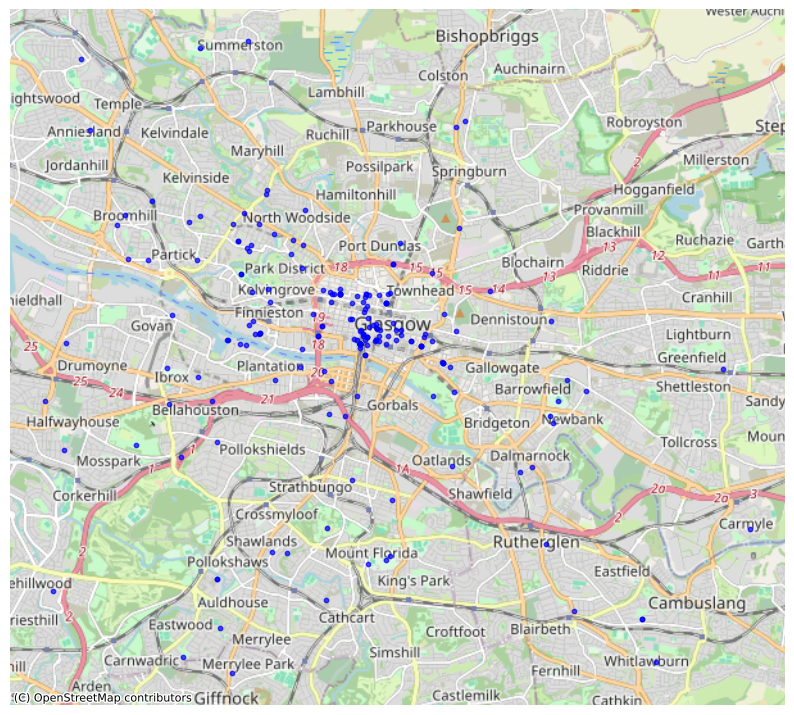

In [6]:
# Plot with a basemap
fig, ax = plt.subplots(figsize=(10, 10))
gla_gdf.plot(ax=ax, marker='o', color='blue', markersize=10, alpha=0.7)
#ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()  # Remove axis for cleaner look
plt.show()

## Use the Together.AI API to batch classify the Tweets as how likely they are to be related to gentrification.

A function that takes a batch of tweets and uses the Together API to classify them. The `_system_prompt` variable contains the prompt that will be sent to the API; individual tweets are appended to this.

The LLM requires some parameter values. Here are the settings that chatGPT recommended (with defaults, that I decided not to use, in brackets)

1.	max_tokens:
	-	Recommendation: 50 (200)
	-	Explanation: Since you’re expecting short responses like '1. Score', a small max_tokens value ensures concise outputs without unnecessary verbosity.
	-    _(I actually choose a larger value because the prompt has been designed to get the LLM to stop long before max_tokens is reached and this way it is hopefully less likely to break if we increase the batch size.
2.	temperature:
	-	Recommendation: 0.2 (0.7)
	-	Explanation: A lower temperature makes the model’s output more deterministic, which is ideal for scoring tasks where consistency is important.
3.	top_p:
	-	Recommendation: 0.9 (0.7)
	-	Explanation: This value balances the randomness and coherence of the output by considering tokens with a cumulative probability up to 90%.
4.	top_k:
	-	Recommendation: 40 (50)
	-	Explanation: Limits the model to consider the top 40 probable next tokens, which helps in generating relevant responses.
5.	repetition_penalty:
	-	Recommendation: 1.1 (1)
	-	Explanation: Slightly penalizes repeated tokens to prevent the model from producing redundant information.

In [7]:
_system_prompt = """
Analyze the following tweets to determine their relevance to gentrification.
Consider indicators such as mentions of urban development, demographic shifts, displacement concerns, socioeconomic changes, and cultural transformations.
Assign a score from 1 to 5, where 1 means not suggestive of gentrification and 5 means highly suggestive.
Provide your answer strictly in the format ‘1. Score’, ‘2. Score’, etc., without any additional explanation or commentary.
""" 

In [27]:
def get_gentrification_scores(batch_tweets, batch_index=0, system_prompt=_system_prompt):
    """
    Retrieves gentrification scores for a batch of tweets using the Together AI API.

    Parameters
    ----------
    batch_tweets : pandas.DataFrame
        A DataFrame containing the tweets for the current batch. 
        It must include a 'text' column with the tweet content.
    batch_index : int
        An optional starting index of the current batch. 
        This is used to align the predicted sentiments with the original DataFrame indices.
    system_prompt : str
        An optional system prompt to be sent to the Together AI API.
        The tweet texts will be appended to this prompt.

    Returns
    -------
    ids : list of int
        A list of DataFrame indices corresponding to each tweet in the batch. 
        These indices align with the main DataFrame from which this batch was drawn.
    sentiments : list of str
        A list of predicted gentrification scores for each tweet in the batch. 
        Possible values are 1 (not suggestive of gentrification) to 5 (highly suggestive).
    """

    # Prepare the list of tweets
    tweet_list = "\n".join([f"{idx+1}. {tweet}" 
                            for idx, tweet in enumerate(batch_tweets.text.values)])
    
    # Create the system prompt
    system_prompt = f"{system_prompt}\n\n{tweet_list}"
    #print("PROMPT:", system_prompt, "\n\n")

    # Prepare the messages
    messages = [
        {
            "role": "system",
            "content": system_prompt
        }
    ]

    # Call the API using parameters that ChatGPT recommends for this task
    response = client.chat.completions.create(
        model="meta-llama/Llama-3.2-90B-Vision-Instruct-Turbo",
        messages=messages,
        max_tokens=200,  # length of output
        temperature=0.2,  # lower for more deterministic
        top_p=0.9,  # ??
        top_k=40,  # ??
        repetition_penalty=1,
        stop=["<|eot_id|>", "<|eom_id|>"],
        truncate=130560,  # ??
        stream=False  # Set stream to False to get the full response
    )

    # Extract the assistant's reply and get the IDs and scores
    assistant_reply = response.choices[0].message.content.strip()
    ids = []
    scores = []

    # re pattern for matches lines like '1. 2' and captures the two numbers
    pattern = r'^\s*(\d+)\s*\.\s*(\d+)\s*$'
    
    # Desipte being told not to, sometimes the reply starts with 'Here are the scores:'.
    # Remove that, and any whitespace at the start or end
    assistant_reply = re.sub(r'^\s*Here are the scores:\s*', '', assistant_reply).strip()

    # Analyse the reply line-by-line
    lines = assistant_reply.strip().split('\n')
    error_count = 0  # Return -1 on an error (and count the number of errors at the same time)
    for i, line in enumerate(lines):
        match = re.match(pattern, line)
        if match:
            # Extract the index and score from the match groups
            index = int(match.group(1))
            score = int(match.group(2))
            # Validate the score range
            if 1 <= score <= 5:
                ids.append(index)
                scores.append(score)
            else:
                print(f"Warning: Score {score} out of range on line {i}: '{line}'")
                error_count += 1
        else:
            print(f"\n*********************"
                  f"Warning: Invalid format on line {i}: '{line}'."
                  f"The full response was: \n{assistant_reply}"
                  f"*********************\n")
            error_count += 1
            break
    
    if error_count > 0:
        # There was an error, set scores to -1 and assume tweet IDs from
        # 1 to len(batch_tweets).
        scores = [-1] * len(batch_tweets)
        ids = [x+1 for x in range(len(batch_tweets))]
        # Do I need to also set the indices as the ids array may not have been populated
    
    # Compute dataframe indices
    df_ids = [batch_index + int(id) - 1 for id in ids]

    #print("ids:", ids)
    #print("scores:", scores)
    
    assert len(df_ids) == len(scores), f"Length of ids ({len(df_ids)} does not match length of scores ({len(scores)})."
    return df_ids, scores

    ## Use regular expressions to extract the scores
    #matches = re.findall(r"(\d+)\.\s*(1|2|3|4|5)", assistant_reply, re.IGNORECASE)

    ## Check that the numbering is correct (optional)
    ## You can add code here to verify the numbering matches the tweets

    ## Compute the actual DataFrame indices
    #ids = [batch_index + int(idx) - 1 for idx, score in matches]
    #scores = [int(score) for idx, score in matches]
    #assert len(ids) == len(scores)

    #return ids, scores


In [ ]:
# Get the API key from a file
with open('together.ai_key.txt', 'r') as f:
    api_key = f.readline().strip()

client = Together(api_key=api_key)

# List of tweets to classify (can sample if I want to)
#df = tweets_df.sample(100).copy()
df = gla_gdf.copy()

print(f"Will query the LM for {len(df)} tweets")

assert len(df) < 500, "Too many tweets to process in one go. Please reduce the number of tweets."

# Ensure the index is consecutive and ascending
df = df.reset_index(drop=True)
# To store the results
df['gentrification_prediction'] = None

# Batch processing
batch_size = 20
for i in range(0, len(df), batch_size):
    # Get the batch of tweets
    batch_tweets = df.loc[i:i + batch_size - 1, :]

    # Get sentiments using the function
    print(f"Submitting batch {i//len(batch_tweets)+1} of {len(df)//len(batch_tweets)}...")

    ids, sentiments = get_gentrification_scores(batch_tweets, batch_index=i)

    #for idx, score in zip(ids, sentiments):
    #    print(f"\t{idx}: {score}")

    # Update the DataFrame with the predictions
    df.loc[ids, 'gentrification_prediction'] = sentiments

print("Finished")

See how well that worked

In [8]:
df.loc[:,['text', 'gentrification_prediction']]

text gentrification_prediction
0                                  New SHAREfactory update adds slow motion_ time lapse_ more https://t.co/nkzB7HZhKa https://t.co/ebEsq7j6wE                         1
1    #12DamesOfChristmas #Super Cutie Alert 😍😍😍💗💗💗Lucy is a fab friendly lass needing a loving home #FFH @NWDogRescue https://t.co/sbr7bo7aYR                         1
2          So many exciting things and we get this beauty on Christmas Day #spacegeek #astronomy #moon #universe #WWP https://t.co/HlrrvxDrAu                         1
3                       #Glasgow #glasgowcentralstation #gigtonight with #therezillos #spizzenergi #punkrockoriginal… https://t.co/4BQSA9i8OS                         1
4                               My Christmas tree ☺️🎄🎅🏼🎁 #Christmas #Tree #Festive #Home #Glasgow @ Oatlands_ Glasgow https://t.co/qQGvdb5yHW                         1
..                                                                                                                                        ...                       ...
195                                                                                                 @stephen_wigmore Such unbridled optimism.                         1
196                             #favouriteplace #puppyunderbed #wontcomeout #bully #bulldog #bulldogdays @ Cambuslang https://t.co/guGaGFg1ol                         1
197                   Embracing every second - I'm the luckiest man alive. Thanks again for your ongoing messages of… https://t.co/vkXpruGn9J                         1
198                       Disco load out was a bit hairy! #thepineapplethief #yourwilderness @ Abc O2 Academy Glasgow https://t.co/7p2nyXOOEV                         1
199                                             Call me_ maybe you will find my voice mail📱 @ Glasgow_ United Kingdom https://t.co/RnLlfDV5LN                         1

[200 rows x 2 columns]

Plot to have a look at the gentrification prediction scores

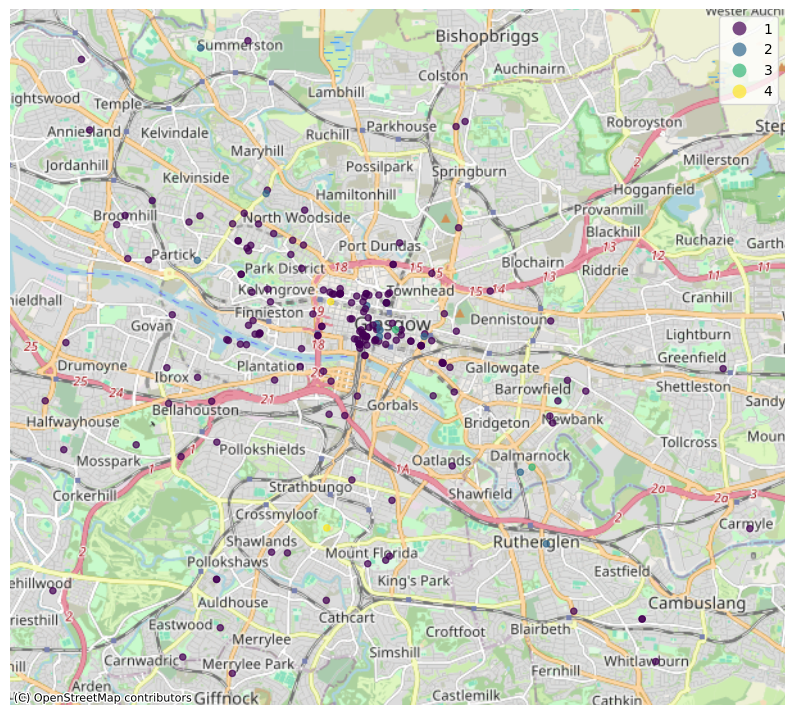

In [9]:
# Plot with a basemap
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame, coloring by 'gentrification_prediction'
df.plot(
    ax=ax,
    marker='o',
    column='gentrification_prediction',
    cmap='viridis',  # You can choose a different colormap if you prefer
    markersize=20,
    alpha=0.7,
    legend=True,  # Add a legend to show the color scale
    #legend_kwds={'title': "Gentrification Prediction", 'orientation': "vertical"}
    
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Remove axis for cleaner look
ax.set_axis_off()

# Display the plot
plt.show()

Interactive map

In [10]:
# Interactive plot using GeoPandas' explore()
m = df.explore(
    column='gentrification_prediction',
    cmap='viridis',
    marker_type='circle_marker',  # Use circle markers
    marker_kwds={'radius': 10, 'fill': True},
    tooltip=['gentrification_prediction'],  # Add tooltips
    legend=True,  # Show legend
    tiles='OpenStreetMap'  # Add a basemap
)
m.save('glasgow_tweet_map.html')
m

## FourSquare Data

Dingqi YANG's has made some [Foursquare data](https://sites.google.com/site/yangdingqi/home/foursquare-dataset) avaiable. In particular, the 'NYC Restaurant Rich Dataset (Check-ins, Tips, Tags)' is potentially useful as it has Tips, which are text. I have downloaded this (dataset_ubicomp2013.zip) and extracted it to [dataset_ubicomp2013](./dataset_ubicomp2013).


In [9]:
foursquare = pd.read_csv(
    os.path.join('dataset_ubicomp2013', 'dataset_ubicomp2013_tips.txt'),
    encoding='latin1', sep='\t', names=["userid", "venueid", "text"])

foursquare

userid  venueid                                                                                                                                                                                       text
0       24436       15                                                                               make your own sandwich: tuna salad on country white bread, cheddar, lettuce, tomato, cucumber, mayo. yuuuum.
1        8550       20                                                          The calamari as an appetizer and the quail. Pretty good, if a bit rich. The berry and creme desert thing was really, really good!
2        1537       20                                                                                                         Be careful with the napkins on your pants. They leave remnants behind. As in lint.
3       59283       20                                                                                                                                           try the steak frites, it's the best - believe me
4         713       20                                                                                                                                go visit google across the street. see the big coffee robot
...       ...      ...                                                                                                                                                                                        ...
10372    2677  2358357                                                                                                                    Way too crowded due to the construction at 7th & Fig .. not my favorite
10373   48037  2376156                                                                                                                                                                 Not for the faint of heart
10374  231830  2376156                              It's goin down Tonight on The Stage (Open Mic for Singers) w\/Live Band hosted by KeShay at NKC 1408 Webster St\/Oakland @9pm NO COVER CHARGE! See You There!
10375   22278  2422200   In 2011, 60% of the 25,000 orange, red and white light bulbs will be LED. The conversion to LED will be complete by 2013 and will save Texas Tech an estimated 80% on electricity costs.
10376   22278  2422200  Developed by Harold Hinn & the Residence Halls Association in 1959, this event was originally called the Christmas Sing, In 2011, the 53rd Carol of Lights will be held on Saturday, 12-3

[10377 rows x 3 columns]

How long are these texts? (Want to get an idea if they are comparible to tweets)

<Axes: >

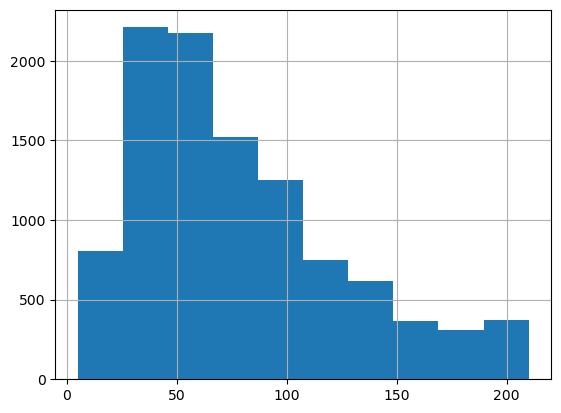

In [14]:
foursquare.text.str.len().hist()

They're simililar. Fine.

Try a slightly different and more specific prompt

In [17]:
foursquare_prompt = """
You are an expert in urban studies with a deep understanding of gentrification and how it is discussed in public discourse. I will provide you with a tweet, and your task is to analyze its text and determine the extent to which it suggests that the neighborhood or area referenced is experiencing gentrification. Specifically:

Read the tweet closely and identify any words, phrases, or implications that might indicate signs of gentrification, such as mentions of new luxury developments, rising rents, displacement of long-time residents, upscale amenities (e.g., artisanal coffee shops, craft breweries), changing demographics, or neighborhood ‘revitalization.’

Consider both explicit and implicit cues. Explicit cues directly mention new businesses or rising property values, while implicit cues might reflect subtle neighborhood changes.

Assign a score from 1 to 5, where 1 means not suggestive of gentrification and 5 means highly suggestive.

Provide your answer strictly in the format ‘1. Score’, ‘2. Score’, '3. Score', etc., without any additional explanation or commentary.
"""

In [28]:
# Get the API key from a file
with open('together.ai_key.txt', 'r') as f:
    api_key = f.readline().strip()

client = Together(api_key=api_key)

# List of tweets to classify (can sample if I want to)
#df = tweets_df.sample(100).copy()
df = foursquare.sample(200)

print(f"Will query the LM for {len(df)} tweets")

assert len(df) < 500, "Too many tweets to process in one go. Please reduce the number of tweets."

# Ensure the index is consecutive and ascending
df = df.reset_index(drop=True)
# To store the results
df['gentrification_prediction'] = None

# Batch processing
batch_size = 20
for i in range(0, len(df), batch_size):
    # Get the batch of tweets
    batch_tweets = df.loc[i:i + batch_size - 1, :]

    # Get sentiments using the function
    print(f"Submitting batch {i // len(batch_tweets) + 1} of {len(df) // len(batch_tweets)}...")

    ids, sentiments = get_gentrification_scores(batch_tweets, batch_index=i, system_prompt=foursquare_prompt)

    #for idx, score in zip(ids, sentiments):
    #    print(f"\t{idx}: {score}")

    # Update the DataFrame with the predictions
    df.loc[ids, 'gentrification_prediction'] = sentiments

print("Finished")

Will query the LM for 200 tweets
Submitting batch 1 of 10...
Submitting batch 2 of 10...
Submitting batch 3 of 10...
Submitting batch 4 of 10...
Submitting batch 5 of 10...

*********************Warning: Invalid format on line 0: '1. Score: 1'.The full response was: 
1. Score: 1
2. Score: 1
3. Score: 4 (fava bean crostini implies upscale cuisine)
4. Score: 5 (description of a "classy cozy bar" in a previously undesirable area implies gentrification)
5. Score: 1
6. Score: 1
7. Score: 1
8. Score: 1
9. Score: 1
10. Score: 1
11. Score: 1
12. Score: 1
13. Score: 1
14. Score: 1
15. Score: 1
16. Score: 4 (mention of jalapeno tequila and upscale Mexican dishes implies a trendy, gentrified establishment)
17. Score: 1
18. Score: 1
19. Score: 1
20. Score: 4 (in-house potato chips imply a*********************

Submitting batch 6 of 10...
Submitting batch 7 of 10...

*********************Warning: Invalid format on line 0: '1. Score: 1'.The full response was: 
1. Score: 1
2. Score: 1
3. Score: 1
4. 

In [30]:
df

userid  venueid                                                                                                                                                                                           text gentrification_prediction
0     38456    13233                                                                                                                                              The espresso is burned. The grinding is too fine.                         1
1     72170    79919         Breakfast wraps are pretty tasty and filling and only $3.26 (incl. tax) right now. Thai Chicken Wrap & Ostrich burger are also satisfying. Smoothies = not worth the calories\/points.                         1
2       953    19417                                                                                                                                      Queens Brazilian- incredible!! get the chicken malagueta.                         1
3    222298    32420                                                                                                     They had to move to 37th and 5th. Get off at the 36th street D N R stop. Best tacos in NYC                         1
4     80608     1163                                                                                                                                     speciality mix drinks. you MUST try the Chocolate martini.                         1
..      ...      ...                                                                                                                                                                                            ...                       ...
195   82569     9111  These guys brought all sorts of delicious hummus (hummi?) with assorted toppings served with pita bread for Choice Eats! You know it's good hummus when it stands out among all those dishes!                         1
196  229664      648                                                                                                                            Dinner was amazingg. Their lemon tart is the best I've tasted in NY                         1
197  247092    16254                                                                                                                                                                      Best Falafel in the city!                         1
198    9253    77986                                                                                                                                                            Portions are enormous so order well                         1
199   24873    98624                                                                                                                    Try the Pear And Blackberry Tart - Nom nom nom dessert  (via @Foodspotting)                         1

[200 rows x 4 columns]